In [1]:
from torch.utils.tensorboard import SummaryWriter
import os
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from d2l import torch as d2l


/home/whr-pc-ubuntu/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/whr-pc-ubuntu/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
log_dir = './logs'

In [3]:
os.popen(f"rm -rf {log_dir}")

In [3]:
writer = SummaryWriter(log_dir)

# scalar

单独add_scalar会将日志直接放到log_dir下面

![image-20230302154321173](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230302154321173.png)

In [5]:
epoch = 30

for e in range(epoch):
    y = e
    writer.add_scalar('y=e',y,e)

# scalars

参数:

    main_tag: 子目录命名的第一部分

    dict:
        {
            sub_tag:data
        }
    
    step

会为某一种data在log_dir下面创建一个子目录, 命名为{main_tag}_sub_tag

![image-20230302154642905](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230302154642905.png)

In [6]:
epoch = 30

for e in range(epoch):
    y_1 = e**2
    y_2 = e**3
    writer.add_scalars('add scalars',{"y=e^2":y_1,"y=e^3":y_2},e)

# image

还是直接输出到log_dir目录下, 和scalar放在同一个文件中,而不是单独生成一个文件

可以通过滚动条，选择某个step对应的image

![image-20230302162225426](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230302162225426.png)

In [7]:
# 加载数据
dataset_path = '/home/whr-pc-ubuntu/code/dataset'
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.MNIST(
    dataset_path,
    train=True,
    transform=transform,
    )

for i in range(10):
    img = train_dataset[i][0] * 255
    writer.add_image('mnist',img,i+1)

# graphs

将lenet作为模型

参数:
    
    net: 网络

    input: 可以从模型的训练数据中提取一部分, 比如用next(iter(train_dataloader)), 这样输入的数据有batch_size组

        但不能是train_dataset[0][0]这种, 因为缺少batch_size这个维度

        可以用train_dataset[0][0].unsqueeze(0)新增一个第0维

存储时, 一种模型只会生成一个graph, 只可能在batch_sizes这个值上存在差别

In [8]:
def load_data(seed=0, batch_size=256, shuffle=True):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081)),
    ])
    dataset_path = '/home/whr-pc-ubuntu/code/dataset'

    train_dataset = torchvision.datasets.MNIST(
        dataset_path,
        True,
        transform,
        download=True,
    )
    test_dataset = torchvision.datasets.MNIST(
        dataset_path,
        False,
        transform,
        download=True,
    )

    torch.manual_seed(seed)
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle)

    return train_dataloader, test_dataloader


In [9]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # 在给各个层的参数赋值时，需要知道上一层的输出维度
        self.conv2d_1 = nn.Conv2d(1,6,kernel_size=(5,5),padding=(2,2)) # 28 - 5 + 1 + 2 + 2 = 28
        self.avg_pool = nn.AvgPool2d((2,2),stride=(2,2)) # (28 - 2 + 1 ) / 2 = 
        self.conv2d_2 = nn.Conv2d(6,16,kernel_size=(5,5))
        self.flat = nn.Flatten() # 保留batch_size这个维度，其他都展开
        self.fc_1 = nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.ReLU()
            )
        self.fc_2 = nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU(),
            )
        self.fc_3 = nn.Linear(84,10)

    def init_params(self,seed):
        torch.manual_seed(seed)
        for layer in self.children():
            if isinstance(layer,nn.Conv2d) or isinstance(layer,nn.Linear):
                # 参数初始化方法一般与激活函数有关
                # Relu-kaming
                # sigmod-xavier
                nn.init.xavier_normal_(layer.weight.data)
                nn.init.zeros_(layer.bias.data)

    def forward(self,x):
        # 第一个维度应该是batch_size
        # print(x.shape) # torch.Size([256, 1, 28, 28])
        
        y = self.conv2d_1(x)
        # print(y.shape) # torch.Size([256, 6, 28, 28])
        
        y = self.avg_pool(y)
        # print(y.shape) # torch.Size([256, 6, 14, 14])
        
        y = self.conv2d_2(y)
        # print(y.shape) # torch.Size([256, 16, 10, 10])

        y = self.avg_pool(y)
        # print(y.shape) # torch.Size([256, 16, 5, 5])

        y = self.flat(y)
        # print(y.shape) # torch.Size([256, 400])

        y = self.fc_1(y)
        # print(y.shape) # torch.Size([256, 120])
        
        y = self.fc_2(y)
        # print(y.shape) # torch.Size([256, 84])

        y = self.fc_3(y)
        # print(y.shape) # torch.Size([256, 10])

        return y



In [10]:
def train(net: CNN, seed, epoch, lr, train_dataloader, test_dataloader):
    # 训练模型，返回最后一轮训练时的loss
    net.init_params(seed)
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='train loss')
    for i in range(epoch):
        accumulator = d2l.Accumulator(2)
        torch.manual_seed(seed)
        for x, y in train_dataloader:
            optimizer.zero_grad()
            y_hat = net(x)
            loss = loss_func(y_hat, y)
            loss.backward()
            optimizer.step()

            accumulator.add(loss, x.shape[0])

        loss = accumulator[0] / accumulator[1]
        animator.add(i+1, (loss,))
    
    return loss


In [11]:
seed = 0
epoch = 20
lr = 0.1
batch_size = 256


In [12]:
test_net = CNN()
train_dataloader, test_dataloader = load_data(batch_size=batch_size, shuffle=False)


KeyboardInterrupt: 

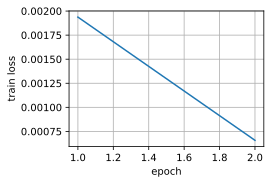

In [13]:
train(test_net, seed, epoch, lr, train_dataloader, test_dataloader)

In [ ]:
writer.add_graph(test_net,next(iter(train_dataloader))[0])


In [14]:
net = CNN()
writer.add_graph(net, train_dataset[0][0].unsqueeze(0))


# distributions

参数:

    tag: 一般理解为是什么层的什么参数

    data: torch.Tensor类型, 一般通过param.data()获得

    step: 一般是epoch

显示模型参数的分布区间(在某个区间的频数/总数), 分布密集的区间用深色表示, 分布稀疏的区间用浅色表示

对比不同epoch下的分布区间, 可以知道在训练迭代过程中, 模型参数是否得到有效的更新

如果要访问所有层(有可训练的参数), 可以用net.named_parameter()迭代所有层的参数(比如weight, bias), 并且可以知道对某个参数的命名

对于一个好的训练过程，模型参数的分布至少应该发生变化，下面的分布图对应的loss曲线如下：

![image-20230302201802353](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230302201802353.png)

![image-20230302202148789](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230302202148789.png)



如果训练过程不行，比如不进行step更新模型参数：

![image-20230302203343590](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230302203343590.png)

![image-20230302203402647](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230302203402647.png)

In [23]:
for name,param in net.named_parameters(): # (name, parameter)
    print(type(param),type(param.data),name) # name is a string of the form "layer_name.parameter_name"
    
    # display(param.)

<class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'> conv2d_1.weight
<class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'> conv2d_1.bias
<class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'> conv2d_2.weight
<class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'> conv2d_2.bias
<class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'> fc_1.0.weight
<class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'> fc_1.0.bias
<class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'> fc_2.0.weight
<class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'> fc_2.0.bias
<class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'> fc_3.weight
<class 'torch.nn.parameter.Parameter'> <class 'torch.Tensor'> fc_3.bias


## epoch中添加数据

In [34]:
def train_and_histogram(net: CNN, seed, epoch, lr, train_dataloader, test_dataloader,writer:SummaryWriter):
    # 训练模型，返回最后一轮训练时的loss
    net.init_params(seed)
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='train loss')
    
    for e in range(epoch):
        accumulator = d2l.Accumulator(2)
        torch.manual_seed(seed)
        for x, y in train_dataloader:
            optimizer.zero_grad()
            y_hat = net(x)
            loss = loss_func(y_hat, y)
            loss.backward()
            optimizer.step()

            accumulator.add(loss, x.shape[0])
            
        loss = accumulator[0] / accumulator[1]
        animator.add(e+1, (loss,))

        for name,param in net.named_parameters():
            writer.add_histogram(name, param.data,e+1)
            
    return loss


7.909685248935906e-05

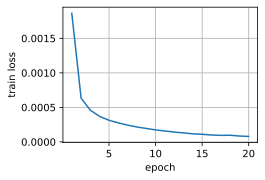

In [35]:
epoch = 20
net = CNN()

train_and_histogram(net,seed,epoch,lr,train_dataloader,test_dataloader,writer)

## epoch中添加数据，不更新模型

In [36]:
def train_and_histogram(net: CNN, seed, epoch, lr, train_dataloader, test_dataloader,writer:SummaryWriter):
    # 训练模型，返回最后一轮训练时的loss
    net.init_params(seed)
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='train loss')
    
    for e in range(epoch):
        accumulator = d2l.Accumulator(2)
        torch.manual_seed(seed)
        for x, y in train_dataloader:
            optimizer.zero_grad()
            y_hat = net(x)
            loss = loss_func(y_hat, y)
            loss.backward()
            # optimizer.step()

            accumulator.add(loss, x.shape[0])
            
        loss = accumulator[0] / accumulator[1]
        animator.add(e+1, (loss,))

        for name,param in net.named_parameters():
            writer.add_histogram(name, param.data,e+1)
            
    return loss


0.008991310719648997

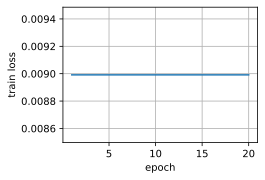

In [37]:
epoch = 20
net = CNN()

train_and_histogram(net,seed,epoch,lr,train_dataloader,test_dataloader,writer)

# text

参数:

    tag

    msg

    step: 一般可以选择epoch或epoch*len(dataloader)+index

text可以用来记录日志, 但对于相同step, 后传入的msg会覆盖之前相同step下的msg

In [7]:
for i in range(10):
    # do sth
    writer.add_text("training output",f"first {i}", i)


![image-20230302210629044](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230302210629044.png)

In [8]:
for i in range(10):
    # do sth
    writer.add_text("training output",f"first {i}", i)
    # do sth
    writer.add_text("training output",f"second {i}", i)


![image-20230302210721651](https://raw.githubusercontent.com/whr819987540/pic/main/image-20230302210721651.png)